In [1]:
# Build variant table from PacBio reads
# Based on: https://github.com/jbloomlab/SARS-CoV-2-RBD_DMS/blob/master/results/summary/build_variants.md
# alignparse-environment

In [ ]:
# this notebook is currently a placeholder
# need to organize data to run from the github repo

In [1]:
# this is taking some time
import yaml
import os
import pandas as pd
import numpy as np
import Bio.SeqUtils.ProtParamData

import alignparse
import alignparse.consensus
import alignparse.targets

import dms_variants
import dms_variants.codonvarianttable
from dms_variants.constants import CBPALETTE
import dms_variants.plotnine_themes

from plotnine import *
import plotnine as p9
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [2]:
# load config.yaml
with open('pkr_config.yaml') as f:
    config = yaml.safe_load(f)
config

{'max_cpus': 16,
 'amplicons': 'input/pacbio_amplicons.gb',
 'primary_target': 'variant-barcode',
 'feature_parse_specs': 'input/feature_parse_specs.yaml',
 'pacbio_runs': 'input/pacbio_runs.csv',
 'ccs_dir': 'input',
 'summary_dir': 'output/summary',
 'process_ccs_dir': 'output/process_ccs',
 'processed_ccs_file': 'output/process_ccs/processed_ccs.csv',
 'variants_dir': 'output/variants',
 'nt_variant_table_file': 'output/variants/nucleotide_variant_table.csv',
 'codon_variant_table_file': 'output/variants/codon_variant_table.csv',
 'counts_dir': 'output/counts',
 'variant_counts_file': 'output/counts/variant_counts.csv',
 'figs_dir': 'output/figures',
 'min_ccs_accuracy': 0.999,
 'min_ccs_passes': 3,
 'min_ccs_length': 50,
 'max_ccs_length': 5000,
 'max_error_rate': 0.0001}

In [3]:
# make variants and figures output directories
os.makedirs(config['variants_dir'], exist_ok=True)
os.makedirs(config['figs_dir'], exist_ok=True)

In [4]:
# import processed_ccs_file made in nb #1
processed_ccs = pd.read_csv(config['processed_ccs_file'], na_filter=None)
nlibs = processed_ccs['library'].nunique()  # number of unique libraries

ntargets = processed_ccs['target'].nunique()  # number of unique targets

print(f"Read {len(processed_ccs)} CCSs from {nlibs} libraries and {ntargets} targets.")

Read 703480 CCSs from 1 libraries and 1 targets.


In [5]:
# head
processed_ccs.head()

,library,query_name,gene_mutations,gene_accuracy,barcode,barcode_accuracy,target
0,pkr_lib,m54313U_220729_065631/1/ccs,C1491T C1492G C1495A G1497A T1500C C1503T,0.999757,CGTATAACTAAGAACACGTTTTGAAC,0.999996,pkr_agei-noti
1,pkr_lib,m54313U_220729_065631/2/ccs,A1440T C1441T T1443G C1444T T1446G T1449C A1452T,0.999682,AAGCCAATGCACAAGGCTGTTCGGGC,0.999891,pkr_agei-noti
2,pkr_lib,m54313U_220729_065631/12/ccs,G1356A C1357A A1359G C1362T A1363G,1.000000,AAGGAAAACGAGAATTGAGTTACTCG,1.000000,pkr_agei-noti
3,pkr_lib,m54313U_220729_065631/30/ccs,C1357A A1359G C1362T T1364C,1.000000,GGCGTAATAACAAATCAACTTATCAA,1.000000,pkr_agei-noti
4,pkr_lib,m54313U_220729_065631/45/ccs,G1456A T1461A C1463G,0.999536,ACTACAATGCGAAAATATATTTGTCA,1.000000,pkr_agei-noti


In [6]:
# stats
(processed_ccs
    .groupby(['target', 'library'])
    .aggregate(total_CCSs=('barcode','size'),unique_barcodes=('barcode','nunique'))
    .assign(avg_CCSs_per_barcode=lambda x: x['total_CCSs'] / x['unique_barcodes'])
    .round(2))

,,total_CCSs,unique_barcodes,avg_CCSs_per_barcode
target,library,,,
pkr_agei-noti,pkr_lib,703480,24819,28.34


(0.0, 5000.0)

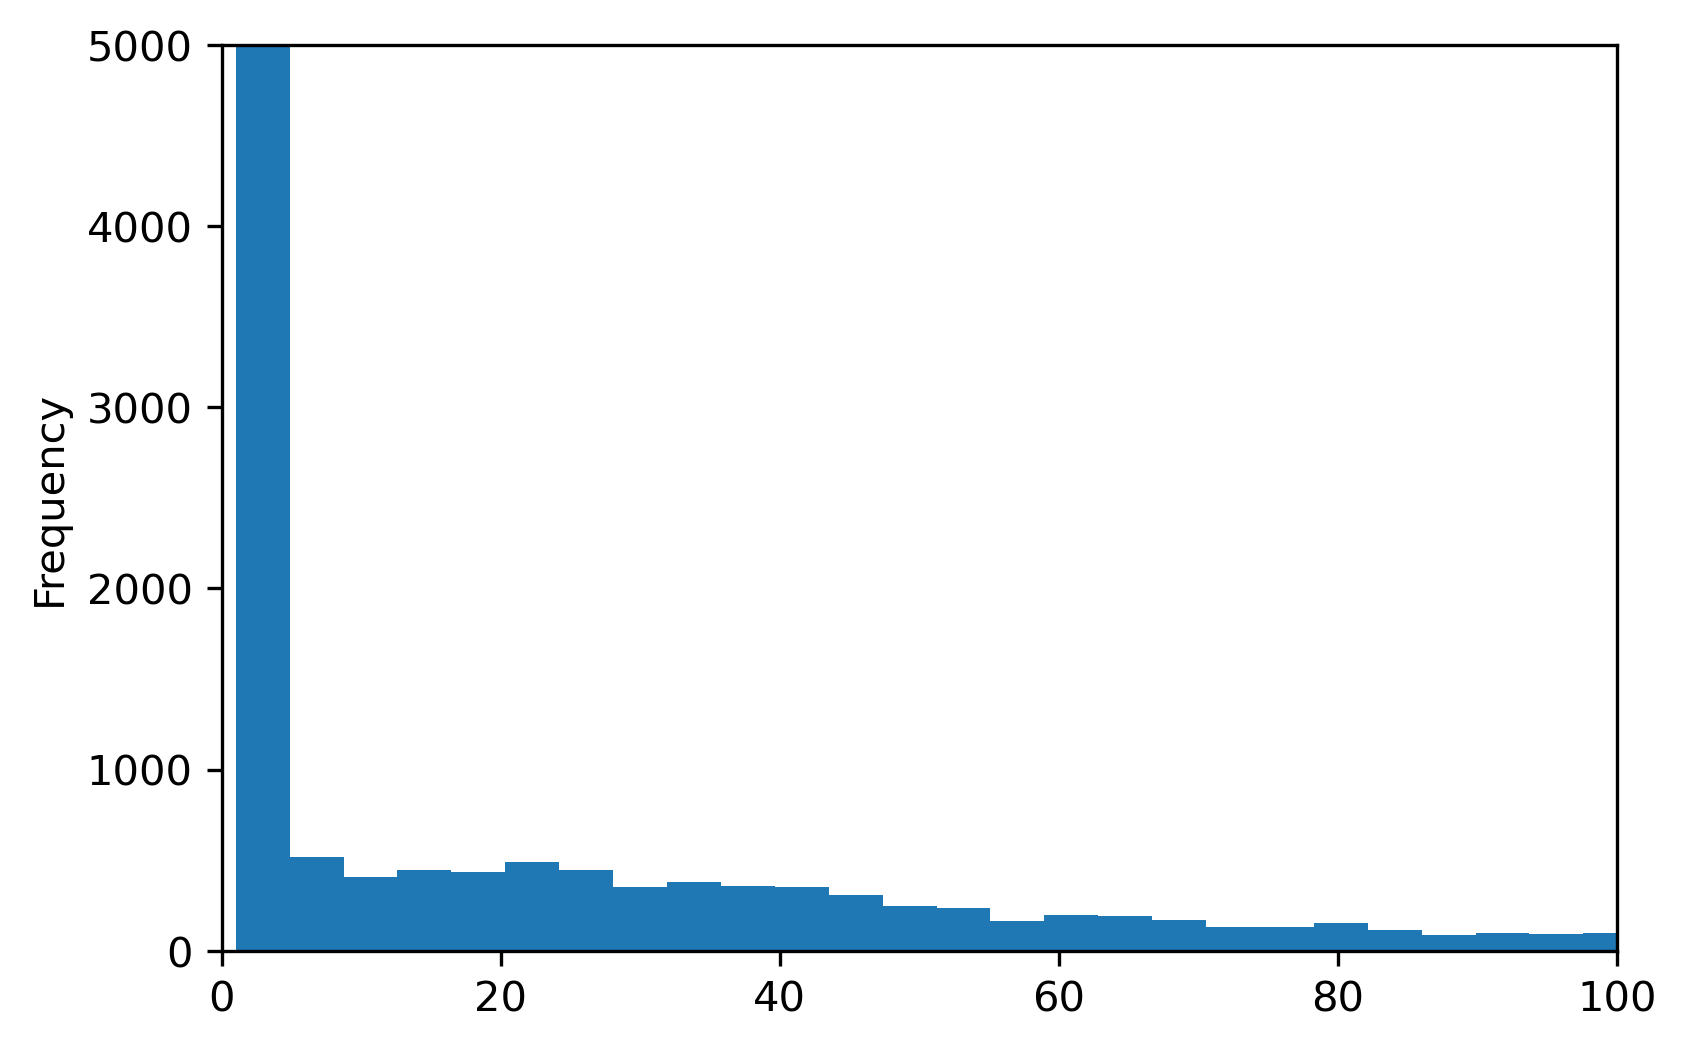

In [7]:
# view number of ccs for pkr 
processed_ccs[processed_ccs.target == 'pkr_agei-noti'].groupby('gene_mutations')['barcode'].size().sort_values(ascending=False).plot.hist(bins=2000)
plt.xlim(0, 100)
plt.ylim(0, 5000)

In [8]:
# generate barcode and gene error scores
error_rate_floor = 1e-7  # error rates < this set to this
if error_rate_floor >= config['max_error_rate']:
    raise ValueError('error_rate_floor must be < max_error_rate')

processed_ccs = (
    processed_ccs
    .assign(barcode_error=lambda x: np.clip(1 - x['barcode_accuracy'],
                                               error_rate_floor, None),
            gene_error=lambda x: np.clip(1 - x['gene_accuracy'],
                                            error_rate_floor, None)
            )
    )

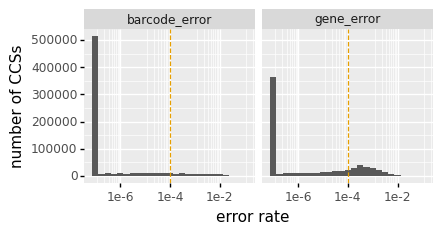

In [9]:
# plot error rates
# max error rate: 0.0001 (dashed line)
_ = (
 ggplot(processed_ccs
        .melt(value_vars=['barcode_error', 'gene_error'],
              var_name='feature_type', value_name='error rate'),
        aes('error rate')) +
 geom_histogram(bins=25) +
 geom_vline(xintercept=config['max_error_rate'],
            linetype='dashed',
            color=CBPALETTE[1]) +
 facet_wrap('~ feature_type') +
 theme(figure_size=(4.5, 2)) +
 ylab('number of CCSs') +
 scale_x_log10()
 ).draw()

In [10]:
# retain reads with error rate 
processed_ccs = (
    processed_ccs
    .assign(retained=lambda x: ((x['gene_error'] < config['max_error_rate']) &
                                (x['barcode_error'] < config['max_error_rate'])))
    )
processed_ccs.head()

,library,query_name,gene_mutations,gene_accuracy,barcode,barcode_accuracy,target,barcode_error,gene_error,retained
0,pkr_lib,m54313U_220729_065631/1/ccs,C1491T C1492G C1495A G1497A T1500C C1503T,0.999757,CGTATAACTAAGAACACGTTTTGAAC,0.999996,pkr_agei-noti,4.024243e-06,2.432913e-04,False
1,pkr_lib,m54313U_220729_065631/2/ccs,A1440T C1441T T1443G C1444T T1446G T1449C A1452T,0.999682,AAGCCAATGCACAAGGCTGTTCGGGC,0.999891,pkr_agei-noti,1.090031e-04,3.183587e-04,False
2,pkr_lib,m54313U_220729_065631/12/ccs,G1356A C1357A A1359G C1362T A1363G,1.000000,AAGGAAAACGAGAATTGAGTTACTCG,1.000000,pkr_agei-noti,1.000000e-07,1.000000e-07,True
3,pkr_lib,m54313U_220729_065631/30/ccs,C1357A A1359G C1362T T1364C,1.000000,GGCGTAATAACAAATCAACTTATCAA,1.000000,pkr_agei-noti,1.000000e-07,1.000000e-07,True
4,pkr_lib,m54313U_220729_065631/45/ccs,G1456A T1461A C1463G,0.999536,ACTACAATGCGAAAATATATTTGTCA,1.000000,pkr_agei-noti,3.873609e-07,4.644856e-04,False


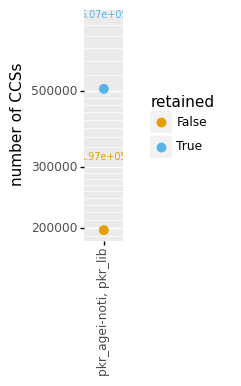

In [11]:
# plot number of retained reads
_ = (
 ggplot(processed_ccs.assign(xlabel=lambda x: x['target'] + ', ' + x['library'])
                     .groupby(['xlabel', 'retained'])
                     .size()
                     .rename('count')
                     .reset_index(),
        aes('xlabel', 'count', color='retained', label='count')) +
 geom_point(size=3) +
 geom_text(va='bottom', size=7, ha='center',format_string='{:.3g}', nudge_y=0.2) +
 theme(figure_size=(0.5 * nlibs * ntargets, 3),
       panel_grid_major_x=element_blank(),
       axis_text_x=element_text(angle=90),
       ) +
 scale_y_log10(name='number of CCSs') +
 xlab('') +
 scale_color_manual(values=CBPALETTE[1:])
 ).draw()

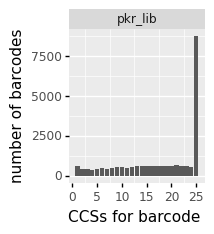

In [12]:
# sequences per barcode
max_count = 25 # in plot, group all barcodes with >= this many counts

p = (
 ggplot(
    processed_ccs
     .query('retained')
     .groupby(['library', 'barcode'])
     .size()
     .rename('nseqs')
     .reset_index()
     .assign(nseqs=lambda x: np.clip(x['nseqs'], None, max_count)),
    aes('nseqs')) +
 geom_bar() +
 facet_wrap('~ library', nrow=1) +
 theme(figure_size=(1.75 * nlibs, 2),
       panel_grid_major_x=element_blank(),
       ) +
 ylab('number of barcodes') +
 xlab('CCSs for barcode')
 )

_ = p.draw()

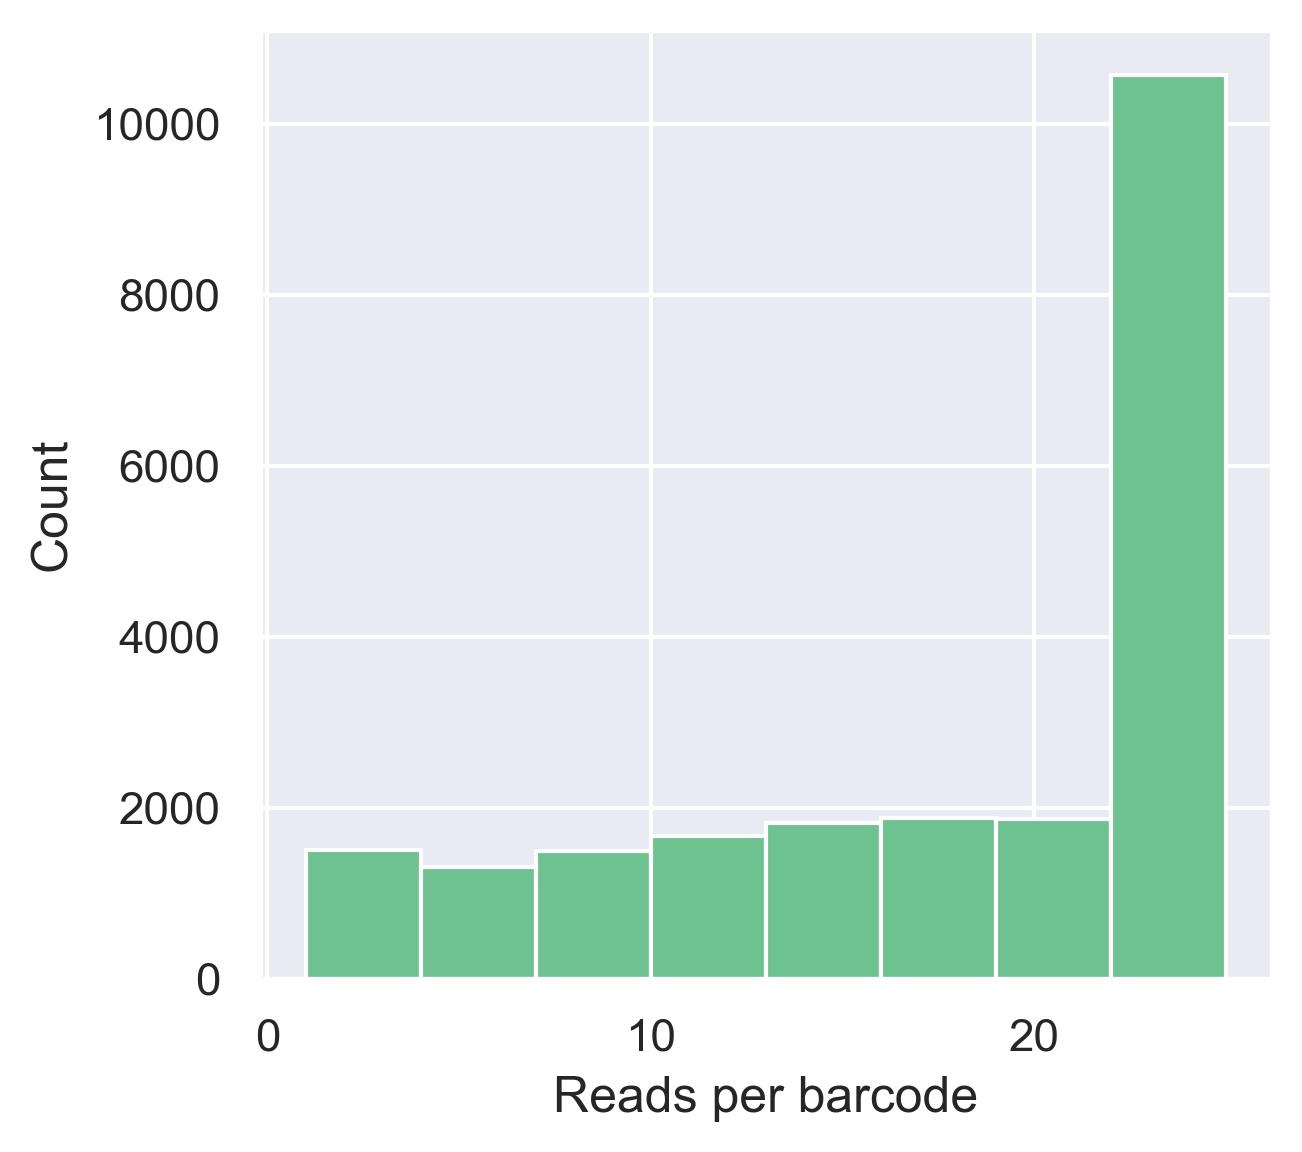

In [15]:
# get reads per barcode for PKR
df = data=processed_ccs.query('retained').groupby(['target', 'barcode']).size().rename('nseqs').reset_index().assign(nseqs=lambda x: np.clip(x['nseqs'], None, max_count))
new_vals = {'pkr_agei-noti':'PKR', 'k3l_bsteii-nrui':'K3L'}
df.replace({'target':new_vals}, inplace=True)

sns.set_theme()
sns.set(rc={'figure.figsize':(4.5,4)})
ax = sns.histplot(data=df[df.target == 'PKR'], x='nseqs', bins=8, alpha=1, color='#6ec290')
ax.set(xlabel='Reads per barcode')
fig = ax.get_figure()
plt.tight_layout()
sns.set_context("talk")
fig.savefig('img/pkr_reads-per-barcode.png')
plt.show()

In [16]:
# get CCS for barcode by target
max_count = 8 # in plot, group all barcodes with >= this many counts

p = (
 ggplot(processed_ccs.query('retained').groupby(['target', 'barcode']).size().rename('nseqs').reset_index().assign(nseqs=lambda x: np.clip(x['nseqs'], None, max_count)),
    aes('nseqs')) +
 geom_bar() +
 facet_wrap('~ library', nrow=1) +
 theme(figure_size=(1.75 * nlibs, 2),
       panel_grid_major_x=element_blank(),
       ) +
 ylab('number of barcodes') +
 xlab('CCSs for barcode')
 )

_ = p.draw()

PlotnineError: 'At least one layer must contain all variables used for facetting'

In [13]:
# mark sequences with indels
processed_ccs = alignparse.consensus.add_mut_info_cols(processed_ccs,
                                                       mutation_col='gene_mutations',
                                                       n_indel_col='n_indels')

processed_ccs = processed_ccs.assign(has_indel=lambda x: x['n_indels'] > 0)

In [14]:
processed_ccs.groupby('target')['has_indel'].value_counts()

target         has_indel
pkr_agei-noti  False        524192
               True         179288
Name: has_indel, dtype: int64

In [15]:
processed_ccs.head()

,library,query_name,gene_mutations,gene_accuracy,barcode,barcode_accuracy,target,barcode_error,gene_error,retained,n_indels,has_indel
0,pkr_lib,m54313U_220729_065631/1/ccs,C1491T C1492G C1495A G1497A T1500C C1503T,0.999757,CGTATAACTAAGAACACGTTTTGAAC,0.999996,pkr_agei-noti,4.024243e-06,2.432913e-04,False,0,False
1,pkr_lib,m54313U_220729_065631/2/ccs,A1440T C1441T T1443G C1444T T1446G T1449C A1452T,0.999682,AAGCCAATGCACAAGGCTGTTCGGGC,0.999891,pkr_agei-noti,1.090031e-04,3.183587e-04,False,0,False
2,pkr_lib,m54313U_220729_065631/12/ccs,G1356A C1357A A1359G C1362T A1363G,1.000000,AAGGAAAACGAGAATTGAGTTACTCG,1.000000,pkr_agei-noti,1.000000e-07,1.000000e-07,True,0,False
3,pkr_lib,m54313U_220729_065631/30/ccs,C1357A A1359G C1362T T1364C,1.000000,GGCGTAATAACAAATCAACTTATCAA,1.000000,pkr_agei-noti,1.000000e-07,1.000000e-07,True,0,False
4,pkr_lib,m54313U_220729_065631/45/ccs,G1456A T1461A C1463G,0.999536,ACTACAATGCGAAAATATATTTGTCA,1.000000,pkr_agei-noti,3.873609e-07,4.644856e-04,False,0,False


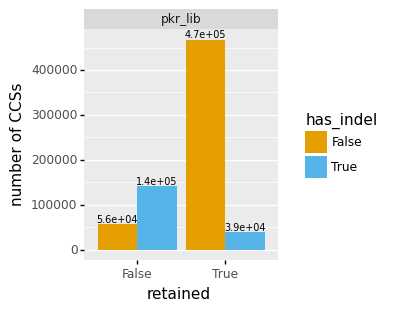

In [16]:
# plot sequences with indels
_ = (
 ggplot(processed_ccs,
        aes('retained', fill='has_indel')) +
 geom_bar(position='dodge') +
 geom_text(aes(label='..count..'), stat='count', va='bottom', size=7,
           position=position_dodge(width=0.9), format_string='{:.2g}') +
 theme(figure_size=(2.5 * nlibs, 3),
       panel_grid_major_x=element_blank(),
       ) +
 ylab('number of CCSs') +
 scale_fill_manual(values=CBPALETTE[1:]) +
 facet_wrap('~ library', nrow=1)
 ).draw()

In [17]:
processed_ccs.head()

,library,query_name,gene_mutations,gene_accuracy,barcode,barcode_accuracy,target,barcode_error,gene_error,retained,n_indels,has_indel
0,pkr_lib,m54313U_220729_065631/1/ccs,C1491T C1492G C1495A G1497A T1500C C1503T,0.999757,CGTATAACTAAGAACACGTTTTGAAC,0.999996,pkr_agei-noti,4.024243e-06,2.432913e-04,False,0,False
1,pkr_lib,m54313U_220729_065631/2/ccs,A1440T C1441T T1443G C1444T T1446G T1449C A1452T,0.999682,AAGCCAATGCACAAGGCTGTTCGGGC,0.999891,pkr_agei-noti,1.090031e-04,3.183587e-04,False,0,False
2,pkr_lib,m54313U_220729_065631/12/ccs,G1356A C1357A A1359G C1362T A1363G,1.000000,AAGGAAAACGAGAATTGAGTTACTCG,1.000000,pkr_agei-noti,1.000000e-07,1.000000e-07,True,0,False
3,pkr_lib,m54313U_220729_065631/30/ccs,C1357A A1359G C1362T T1364C,1.000000,GGCGTAATAACAAATCAACTTATCAA,1.000000,pkr_agei-noti,1.000000e-07,1.000000e-07,True,0,False
4,pkr_lib,m54313U_220729_065631/45/ccs,G1456A T1461A C1463G,0.999536,ACTACAATGCGAAAATATATTTGTCA,1.000000,pkr_agei-noti,3.873609e-07,4.644856e-04,False,0,False


In [21]:
# get empirical accuracy for ccs reads
# not working
# this isn't running, maybe b/c no bc redundancy?
high_acc = config['max_error_rate'] / 10
empirical_acc = []

for desc, query_str in [('retained', 'retained'),('retained, no indel', 'retained and not has_indel'), ('10X accuracy',f"(gene_error < {high_acc}) and (barcode_error < {high_acc})"),('10X accuracy, no indel', f"(gene_error < {high_acc}) and (barcode_error < {high_acc}) and not has_indel")]:
    # get just CCSs in that category
    df = processed_ccs.query(query_str)
    
    # compute empirical accuracy
    empirical_acc.append(
        alignparse.consensus.empirical_accuracy(df,mutation_col='gene_mutations', accuracy_col='accuracy')
        .assign(description=desc)
        .merge(df
               .groupby('library')
               .size()
               .rename('number_CCSs')
               .reset_index()
               )
        )

# make description categorical to preserve order, and annotate as "actual"
# the category ("retained, no indel") that we will use for building variants.
empirical_acc = (
    pd.concat(empirical_acc, ignore_index=True, sort=False)
    .assign(description=lambda x: pd.Categorical(x['description'],
                                                 x['description'].unique(),
                                                 ordered=True),
            actual=lambda x: numpy.where(x['description'] == 'retained, no indel',
                                         True, False),
            )
    )

RuntimeError: optimization failed:
     fun: nan
 message: 'NaN result encountered.'
    nfev: 25
  status: 2
 success: False
       x: 0.3819660136107848

In [19]:
# barcode consensus sequences
# takes some time
consensus, dropped = alignparse.consensus.simple_mutconsensus(
                        processed_ccs.query('retained'),
                        group_cols=('library', 'barcode', 'target'),
                        mutation_col='gene_mutations',
                        )
consensus.head()


In [23]:
dropped.to_csv('output/variants/consensus_dropped.csv', index=False)

In [24]:
# flag variants with indels
consensus = alignparse.consensus.add_mut_info_cols(
                    consensus,
                    mutation_col='gene_mutations',
                    sub_str_col='substitutions',
                    n_indel_col='number_of_indels',
                    overwrite_cols=True)

consensus.head()

,library,barcode,target,gene_mutations,variant_call_support,substitutions,number_of_indels
0,pkr_lib,AAAAAAAAAAAAAATTCTTTTATGAG,pkr_agei-noti,A1440T C1441T T1443A C1444T T1446G T1455C,7,A1440T C1441T T1443A C1444T T1446G T1455C,0
1,pkr_lib,AAAAAAAAAACAAAGAGGTTTATATT,pkr_agei-noti,A825T G827T T834C del839to839,20,A825T G827T T834C,1
2,pkr_lib,AAAAAAAAAACGAAACCCTTTATTTT,pkr_agei-noti,G1456A T1467C A1470G A1473T,2,G1456A T1467C A1470G A1473T,0
3,pkr_lib,AAAAAAAAAACTAATCCATTTTCACA,pkr_agei-noti,A1440G C1441T T1443A C1444T T1446A T1449C A145...,1,A1440G C1441T T1443A C1444T T1446A T1449C A145...,0
4,pkr_lib,AAAAAAAAAAGAAACCTCCTTACTTA,pkr_agei-noti,G1438T A1440G C1441T T1443G C1444T T1446A A145...,5,G1438T A1440G C1441T T1443G C1444T T1446A A145...,0


In [25]:
consensus.to_csv('output/variants/consensus_indels.csv', index=False)

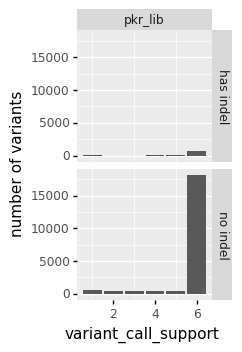

In [26]:
# plot distribution of reads supporting consensus
max_variant_call_support = 6  # group variants with >= this much support

_ = (
 ggplot(consensus
        .assign(variant_call_support=lambda x: np.clip(x['variant_call_support'],
                                                          None,
                                                          max_variant_call_support),
                indel_state=lambda x: np.where(x['number_of_indels'] > 0,
                                                  'has indel', 'no indel')
                ),
        aes('variant_call_support')) +
 geom_bar() +
 ylab('number of variants') +
 facet_grid('indel_state ~ library') +
 theme(figure_size=(1.75 * nlibs, 3.5),
       panel_grid_major_x=element_blank(),
       ) 
 ).draw()

In [33]:
barcodes = [
    'CCATCAAAGGTTAAGGGTATTGCACG',
    'AGAGAAATGAAAAAGGTTCTTGGAGA', # this is a dud
    'TGAACAACATAAAAACAGATTTAACG',
    'CGGCTAATATACAACAGGTTTAACTA',
    'TATATAACTTCTAAGTAGATTAGCCC'
]

dropped[dropped.barcode.isin(barcodes)]

,library,barcode,target,drop_reason,nseqs
370,pkr_lib,CCATCAAAGGTTAAGGGTATTGCACG,pkr_agei-noti,minor subs too frequent,20


In [35]:
consensus[consensus.barcode.isin(barcodes)]

,library,barcode,target,gene_mutations,variant_call_support,substitutions,number_of_indels
10289,pkr_lib,CGGCTAATATACAACAGGTTTAACTA,pkr_agei-noti,G1438A C1441G C1444T T1446G,33,G1438A C1441G C1444T T1446G,0
17472,pkr_lib,TATATAACTTCTAAGTAGATTAGCCC,pkr_agei-noti,A1090G G1115C C1119A A1125G,28,A1090G G1115C C1119A A1125G,0
18934,pkr_lib,TGAACAACATAAAAACAGATTTAACG,pkr_agei-noti,T683A C780T A782T T789C C792T,30,T683A C780T A782T T789C C792T,0


In [32]:
dropped.drop_reason.value_counts()

subs diff too large          426
minor subs too frequent      301
indels diff too large        196
minor indels too frequent      5
Name: drop_reason, dtype: int64

In [28]:
consensus[consensus.barcode == "CCATCAAAGGTTAAGGGTATTGCACG"]

,library,barcode,target,gene_mutations,variant_call_support,substitutions,number_of_indels


,library,target,consensus sequences
0,pkr_lib,pkr_agei-noti,20359


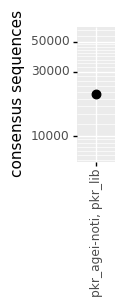

In [26]:
# valid reads without indels
consensus = consensus.query('number_of_indels == 0')

lib_target_counts = (
    consensus
    .groupby(['library', 'target'])
    .size()
    .rename('consensus sequences')
    .reset_index()
    )

p = (ggplot(lib_target_counts.assign(xlabel=lambda x: x['target'] + ', ' + x['library']),
            aes('xlabel', 'consensus sequences')) +
     geom_point(size=3) +
     theme(figure_size=(0.5 * nlibs * ntargets, 1.75),
           axis_text_x=element_text(angle=90)) +
     xlab('') +
     scale_y_log10()
     )

_ = p.draw()

lib_target_counts

In [27]:
# find duplicate barcodes
dup_barcodes = (
    consensus
    .groupby(['library', 'barcode'])
    .size()
    .rename('duplicate_count')
    .reset_index()
    .query('duplicate_count > 1')
    )

print('Here are duplicated barcodes:')
dup_barcodes.head()

print(f"\nRemoving the {len(dup_barcodes)} duplicated barcodes."
      f"Started with {len(consensus)} barcodes:")
consensus = (
    consensus
    .merge(dup_barcodes, on=['library', 'barcode'], how='outer')
    .query('duplicate_count.isnull()', engine='python')
    )
print(f"After removing duplicates, there are {len(consensus)} barcodes.")

Here are duplicated barcodes:

Removing the 0 duplicated barcodes.Started with 20359 barcodes:
After removing duplicates, there are 20359 barcodes.


In [28]:
target_names = consensus['target'].unique().tolist()
out_files = []
for i in target_names:
    df = consensus[consensus['target'] == i][['library', 'barcode', 'substitutions', 'variant_call_support']]
    out_file = config['variants_dir'] + '/' + i + '.nucleotide_variant_table.csv'
    out_files.append(out_file)
    df.to_csv(out_file, index=False)

In [29]:
out_files

['output/variants/pkr_agei-noti.nucleotide_variant_table.csv']

In [30]:
# linked nuc mutations to barcodes
# this doesn't work for my purposes, need individual files for each target
print(f"Writing nucleotide variants to {config['nt_variant_table_file']}")
      
(consensus
 [['target', 'library', 'barcode', 'substitutions', 'variant_call_support']]
 .to_csv(config['nt_variant_table_file'], index=False)
 )
      
print('Here are the first few lines of this file:')

pd.read_csv(config['nt_variant_table_file'], na_filter=None).head()

Writing nucleotide variants to output/variants/nucleotide_variant_table.csv
Here are the first few lines of this file:


,target,library,barcode,substitutions,variant_call_support
0,pkr_agei-noti,pkr_lib,AAAAAAAAAAAAAATTCTTTTATGAG,A1440T C1441T T1443A C1444T T1446G T1455C,7
1,pkr_agei-noti,pkr_lib,AAAAAAAAAACGAAACCCTTTATTTT,G1456A T1467C A1470G A1473T,2
2,pkr_agei-noti,pkr_lib,AAAAAAAAAACTAATCCATTTTCACA,A1440G C1441T T1443A C1444T T1446A T1449C A145...,1
3,pkr_agei-noti,pkr_lib,AAAAAAAAAAGAAACCTCCTTACTTA,G1438T A1440G C1441T T1443G C1444T T1446A A145...,5
4,pkr_agei-noti,pkr_lib,AAAAAAAAACAGAAAGTTATTATTTA,C1506A C1509G A1512T A1518T,32


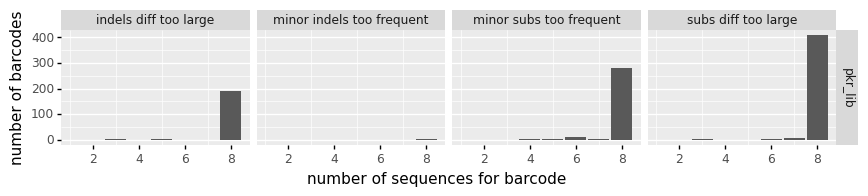

In [31]:
# summarized dropped read data
max_nseqs = 8  # plot together all barcodes with >= this many sequences

_ = (
 ggplot(
    dropped.assign(nseqs=lambda x: np.clip(x['nseqs'], None, max_nseqs)),
    aes('nseqs')) + 
 geom_bar() + 
 scale_x_continuous(limits=(1, None)) +
 xlab('number of sequences for barcode') +
 ylab('number of barcodes') +
 facet_grid('library ~ drop_reason') +
 theme(figure_size=(10, 1.5 * nlibs),
       panel_grid_major_x=element_blank(),
       )
 ).draw()

In [32]:
# create barcode variant table


### NOTE: should 
targets = alignparse.targets.Targets(seqsfile=config['amplicons'], feature_parse_specs=config['feature_parse_specs'])
geneseq = targets.get_target('pkr_agei-noti').get_feature('gene').seq

print(f"Read gene of {len(geneseq)} nts for 'pkr_agei-noti' from {config['amplicons']}")

Read gene of 1656 nts for 'pkr_agei-noti' from input/pacbio_amplicons.gb


In [33]:
out_files

['output/variants/pkr_agei-noti.nucleotide_variant_table.csv']

In [34]:
### PKR START

In [36]:
# create PKR variant table
pkr_file = 'output/variants/pkr_agei-noti.nucleotide_variant_table.csv'

pkr_variants = dms_variants.codonvarianttable.CodonVariantTable(
    barcode_variant_file=pkr_file,
    geneseq=geneseq
)

NameError: name 'geneseq' is not defined

In [36]:
pkr_variants.n_variants_df(samples=None).pivot_table(columns='library',values='count')

library,pkr_lib
count,20359


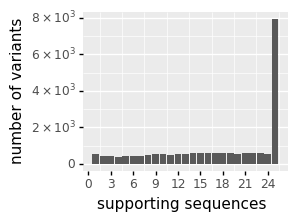

In [38]:
# plot pkr variants
max_support = 25  # group variants with >= this much support

p = pkr_variants.plotVariantSupportHistogram(max_support=max_support,
                                         widthscale=1.1,
                                         heightscale=0.9)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

Saving plot to output/figures/n_aa_muts_per_variant.pdf


/data/chambersmj/conda/envs/alignparse-environment/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 2.75 x 1.8900000000000001 in image.
/data/chambersmj/conda/envs/alignparse-environment/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: output/figures/n_aa_muts_per_variant.pdf


Saving plot to output/figures/n_codon_muts_per_variant.pdf


/data/chambersmj/conda/envs/alignparse-environment/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 2.75 x 1.8900000000000001 in image.
/data/chambersmj/conda/envs/alignparse-environment/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: output/figures/n_codon_muts_per_variant.pdf


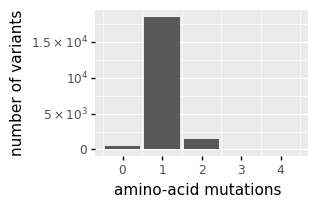

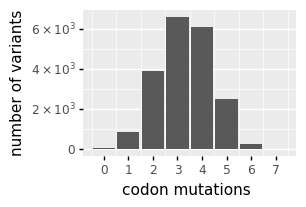

In [39]:
# plot mutations per variant
max_muts = 7  # group all variants with >= this many mutations

for mut_type in ['aa', 'codon']:
    p = pkr_variants.plotNumMutsHistogram(mut_type, samples=None, max_muts=max_muts,
                                      widthscale=1.1,
                                      heightscale=0.9)
    p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
    _ = p.draw()
    plotfile = os.path.join(config['figs_dir'], f"n_{mut_type}_muts_per_variant.pdf")
    print(f"Saving plot to {plotfile}")
    p.save(plotfile)

Saving plot to output/figures/avg_muts_per_variant.pdf


/data/chambersmj/conda/envs/alignparse-environment/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 2.4 x 1.8399999999999999 in image.
/data/chambersmj/conda/envs/alignparse-environment/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: output/figures/avg_muts_per_variant.pdf


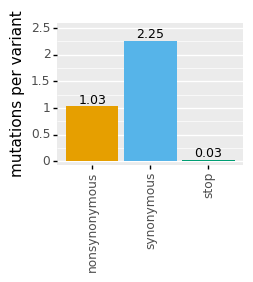

In [40]:
# plot frequencies of different codon mutation types

# doesn't look good, getting WAY more synonymous mutations
p = pkr_variants.plotNumCodonMutsByType(variant_type='all', samples=None,
                                    ylabel='mutations per variant',
                                    heightscale=0.8)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()
plotfile = os.path.join(config['figs_dir'], f"avg_muts_per_variant.pdf")
print(f"Saving plot to {plotfile}")
p.save(plotfile)

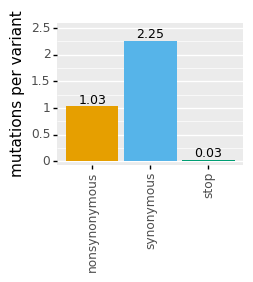

In [41]:
# variants supported by multiple reads (flops for the example dataset)
p = pkr_variants.plotNumCodonMutsByType(variant_type='all', samples=None,
                                    ylabel='mutations per variant', 
                                    min_support=2, heightscale=0.8)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

Saving plot to output/figures/variant_cumul_all_mut_coverage.pdf


/data/chambersmj/conda/envs/alignparse-environment/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 2.9000000000000004 x 2.2 in image.
/data/chambersmj/conda/envs/alignparse-environment/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: output/figures/variant_cumul_all_mut_coverage.pdf


Saving plot to output/figures/variant_cumul_single_mut_coverage.pdf


/data/chambersmj/conda/envs/alignparse-environment/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 2.9000000000000004 x 2.2 in image.
/data/chambersmj/conda/envs/alignparse-environment/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: output/figures/variant_cumul_single_mut_coverage.pdf


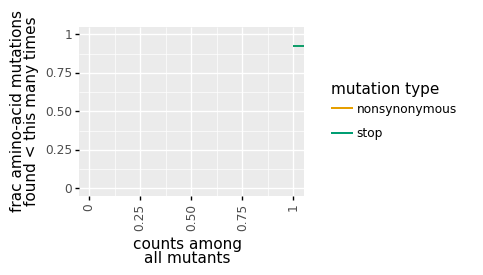

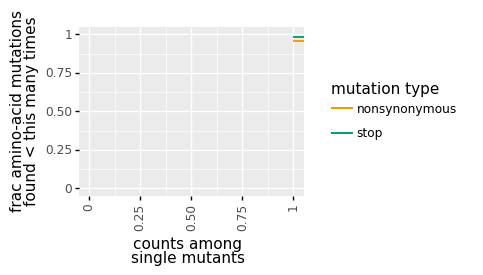

In [42]:
# check for completeness of aa mutations
for variant_type in ['all', 'single']:
    p = pkr_variants.plotCumulMutCoverage(variant_type, mut_type='aa', samples=None)
    _ = p.draw()
    plotfile = os.path.join(config['figs_dir'],
                            f"variant_cumul_{variant_type}_mut_coverage.pdf")
    print(f"Saving plot to {plotfile}")
    p.save(plotfile)

In [43]:
count_dfs = []
for variant_type in ['all', 'single']:
    i_counts = (pkr_variants.mutCounts(variant_type, mut_type='aa', samples=None)
                .assign(variant_type=variant_type)
                )
    count_dfs += [i_counts.assign(include_stops=True),
                  i_counts
                  .query('not mutation.str.contains("\*")', engine='python')
                  .assign(include_stops=False)
                  ]
    
(
    pd.concat(count_dfs)
    .assign(count=lambda x: (np.clip(x['count'], None, 2)
                             .map({0: '0', 1: '1', 2:'>1'}))
            )
    .groupby(['variant_type', 'include_stops', 'library', 'count'])
    .aggregate(number_of_mutations=pd.NamedAgg(column='mutation', aggfunc='count'))
)

number_of_mutations
variant_type include_stops library count                     
all          False         pkr_lib 0                     9705
                                   1                      248
                                   >1                     516
             True          pkr_lib 0                    10234
                                   1                      276
                                   >1                     530
single       False         pkr_lib 0                    10002
                                   1                       29
                                   >1                     438
             True          pkr_lib 0                    10562
                                   1                       33
                                   >1                     445

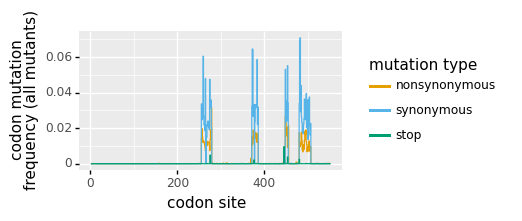

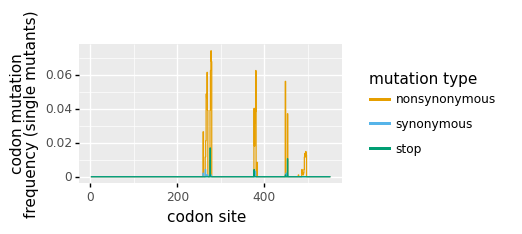

In [44]:
for variant_type in ['all', 'single']:
    p = pkr_variants.plotMutFreqs(variant_type, mut_type='codon', samples=None)
    p.draw()

/data/chambersmj/conda/envs/alignparse-environment/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 3.4000000000000004 x 1.8 in image.
/data/chambersmj/conda/envs/alignparse-environment/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: img/pkr_mutation-frequency.svg
/data/chambersmj/conda/envs/alignparse-environment/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 3.4000000000000004 x 1.8 in image.
/data/chambersmj/conda/envs/alignparse-environment/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: img/pkr_mutation-frequency.pdf
/data/chambersmj/conda/envs/alignparse-environment/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 3.4000000000000004 x 1.8 in image.
/data/chambersmj/conda/envs/alignparse-environment/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: img/pkr_mutation-frequency.png


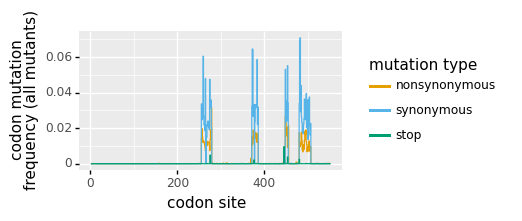

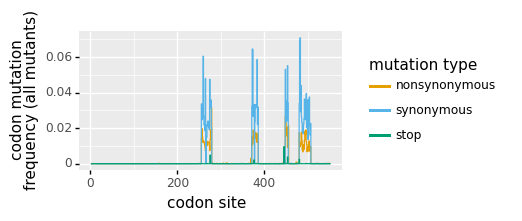

In [45]:
# 
p = pkr_variants.plotMutFreqs('all', mut_type='codon', samples=None)
p.save('img/pkr_mutation-frequency.svg')
p.save('img/pkr_mutation-frequency.pdf')
p.save('img/pkr_mutation-frequency.png')
p.draw()

In [46]:
df = pkr_variants.mutCounts('all','aa', samples=None)

In [47]:
n_variants = pkr_variants.n_variants_df(samples=None).rename(columns={'count': 'nseqs'})
n_variants

,library,sample,nseqs
0,pkr_lib,barcoded variants,20359


In [48]:
pattern = pkr_variants._AA_SUB_RE.pattern
order = [tup[0] for tup in sorted(
                    Bio.SeqUtils.ProtParamData.kd.items(),
                    key=lambda tup: tup[1])] + ['*']

In [49]:
df = (df
    [['library', 'sample', 'mutation', 'site', 'count']]
    .merge(n_variants, on=['library', 'sample'])
    .assign(frequency=lambda x: x['count'] / x['nseqs'],
          mut_char=lambda x: pd.Categorical(
                                    x['mutation'].str
                                    .extract(pattern).mut,
                                    order,
                                    ordered=True,
                                    ).remove_unused_categories()
          )
    )

# should be able to make heatmap from this
df.head()

,library,sample,mutation,site,count,nseqs,frequency,mut_char
0,pkr_lib,barcoded variants,F278L,278,207,20359,0.010167,L
1,pkr_lib,barcoded variants,G277R,277,198,20359,0.009725,R
2,pkr_lib,barcoded variants,R445*,445,196,20359,0.009627,*
3,pkr_lib,barcoded variants,L452F,452,185,20359,0.009087,F
4,pkr_lib,barcoded variants,K449N,449,179,20359,0.008792,N


Saving plot to img/heatmap_pkr-dms.png


/data/chambersmj/conda/envs/alignparse-environment/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.6 x 2.5 in image.
/data/chambersmj/conda/envs/alignparse-environment/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: img/heatmap_pkr-dms.png


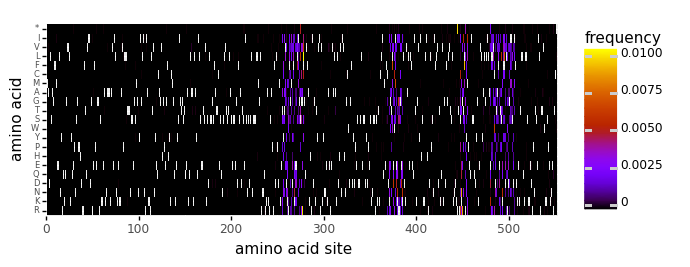

In [50]:
# DMS_variant heatmap
order = [tup[0] for tup in sorted(
                    Bio.SeqUtils.ProtParamData.kd.items(),
                    key=lambda tup: tup[1])] + ['*']
pattern = pkr_variants._AA_SUB_RE.pattern
height_per = 1.7
mut_desc = 'amino acid'
width = (1.6 + 5)
height = (0.8 + height_per)
p = (p9.ggplot(df, p9.aes('site', 'mut_char',
                          fill='frequency')) +
     p9.geom_tile() +
     p9.theme(figure_size=(width, height),
              legend_key=p9.element_blank(),
              axis_text_y=p9.element_text(size=6)
              ) +
     p9.scale_x_continuous(
        name=f'{mut_desc} site',
        limits=(min(df.site) - 1, max(df.site) + 1),
        expand=(0, 0)
        ) +
     p9.ylab(mut_desc) +
     p9.scale_fill_cmap('gnuplot')
     )

_ = p.draw()
plotfile = 'img/heatmap_pkr-dms.png'
print(f"Saving plot to {plotfile}")
p.save(plotfile)


In [51]:
new_df = df.pivot_table(index='site', columns='mut_char', values='frequency')

# my custom aa list
aa_list = ['H','K','R','D','E','C','M','N','Q','S','T','A','I','L','V','F','W','Y','G','P','*']
new_df = new_df[aa_list]

In [52]:


# try to customize the xticks 1-552
num_ticks = 11
# the index of the position of yticks
yticks = np.linspace(0, len(new_df.index) - 1, num_ticks, dtype=np.int)
# the content of labels of these yticks
yticklabels = [new_df.index.tolist()[idx] for idx in yticks]

/tmp/ipykernel_4956/3391645954.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [53]:
yticklabels = range(0,len(new_df.index),50)


In [54]:
yticks

array([  0,  55, 110, 165, 220, 275, 330, 385, 440, 495, 551])

In [55]:
yticklabels

range(0, 552, 50)

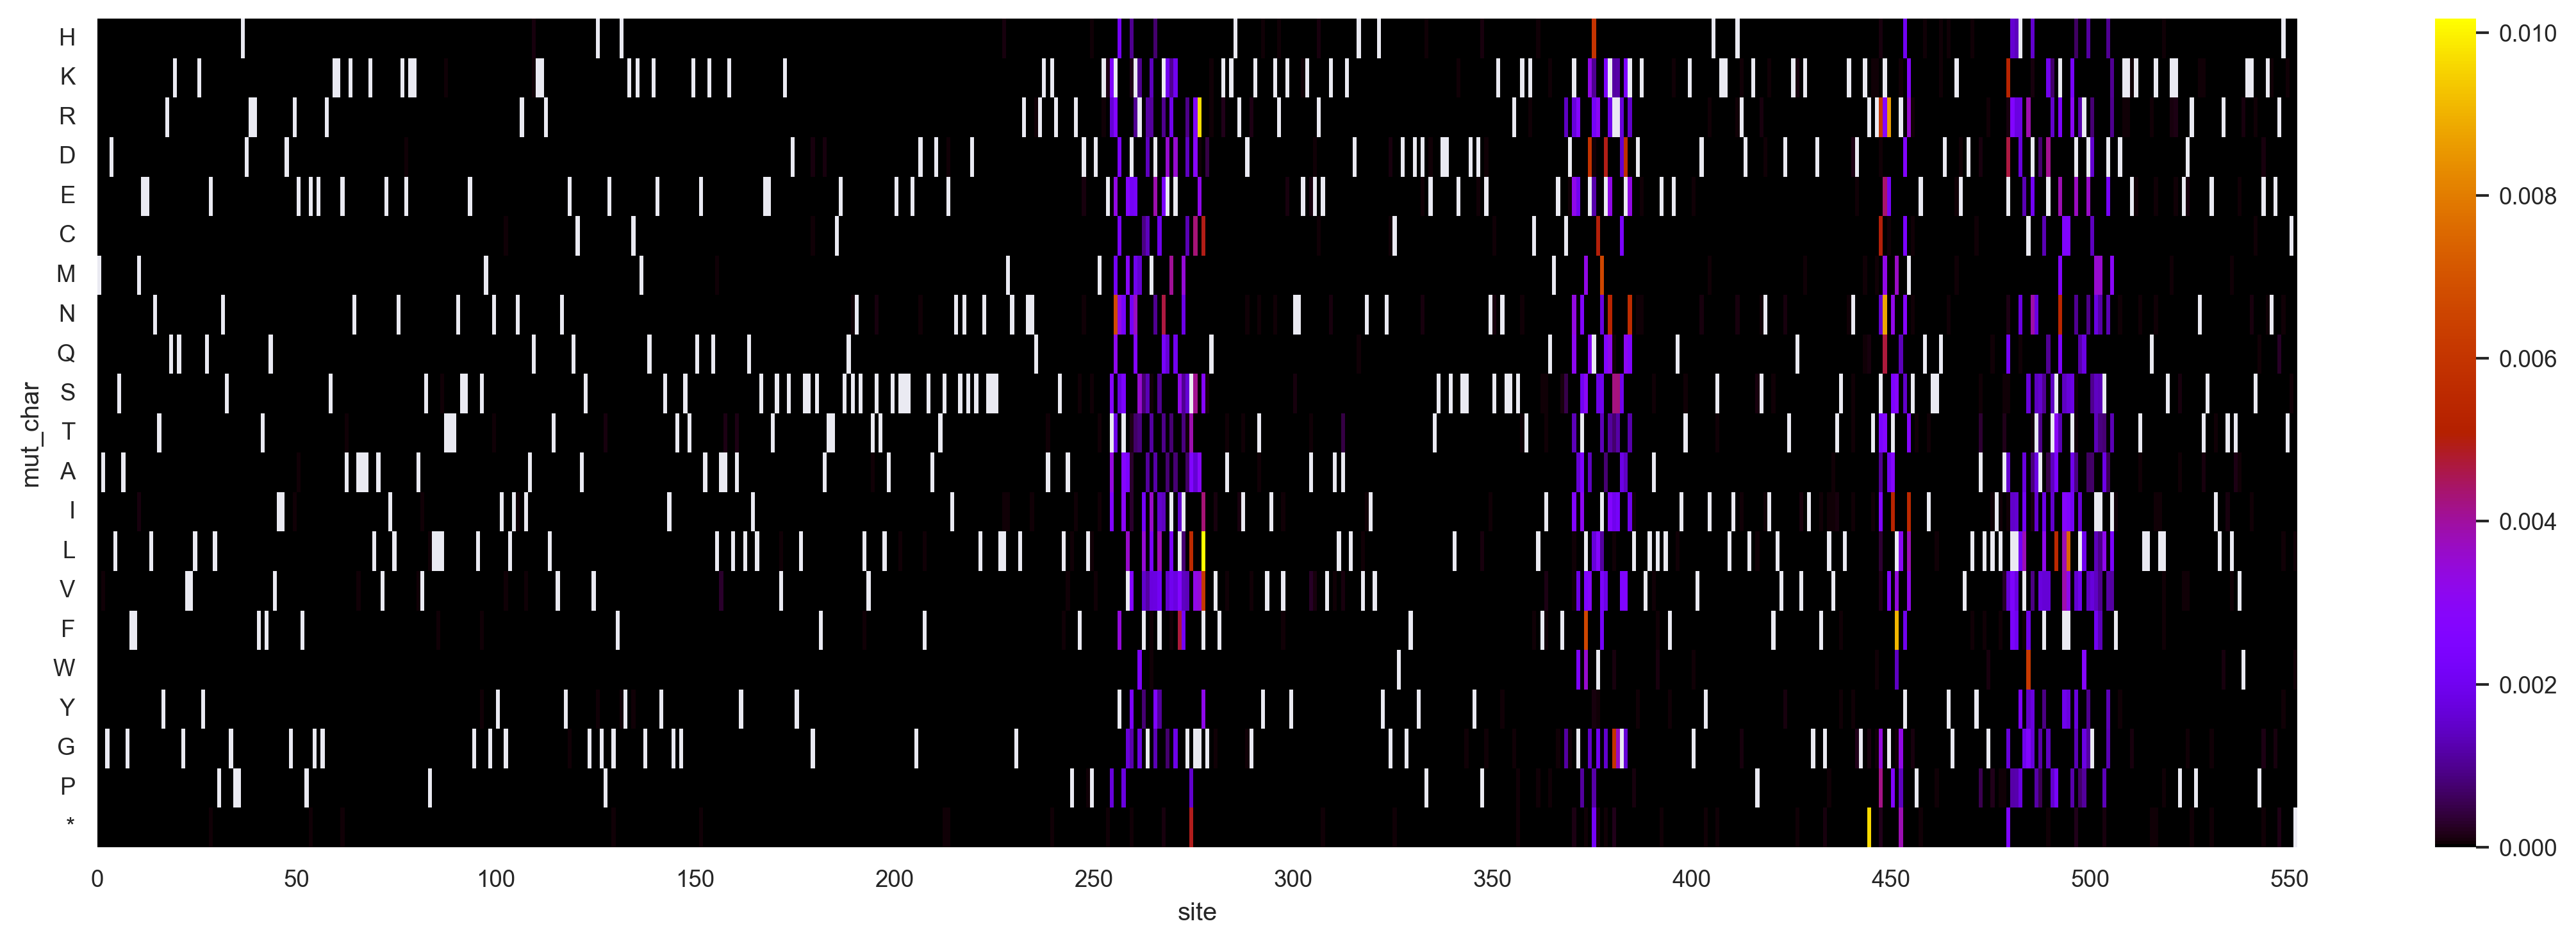

In [56]:
yticklabels = range(0,len(new_df.index),50)

sns.set_context('paper')
plt.figure(figsize=(15,5))
ax = sns.heatmap(data=new_df.T, square=False, cbar=True, cmap='gnuplot')
#ax.set(xlabel='')
#ax.set(ylabel='')
ax.set_xticks(yticklabels)

ax.set_xticklabels(yticklabels, rotation=90)
ax.set_yticklabels(aa_list, rotation=90)# remove the axis label
plt.xticks(rotation=0)
plt.yticks(rotation=0)
fig = ax.get_figure()

plt.tight_layout()
fig.savefig('img/heatmap_pkr-dms.pdf')
fig.savefig('img/heatmap_pkr-dms.svg')
fig.savefig('img/heatmap_pkr-dms.png')

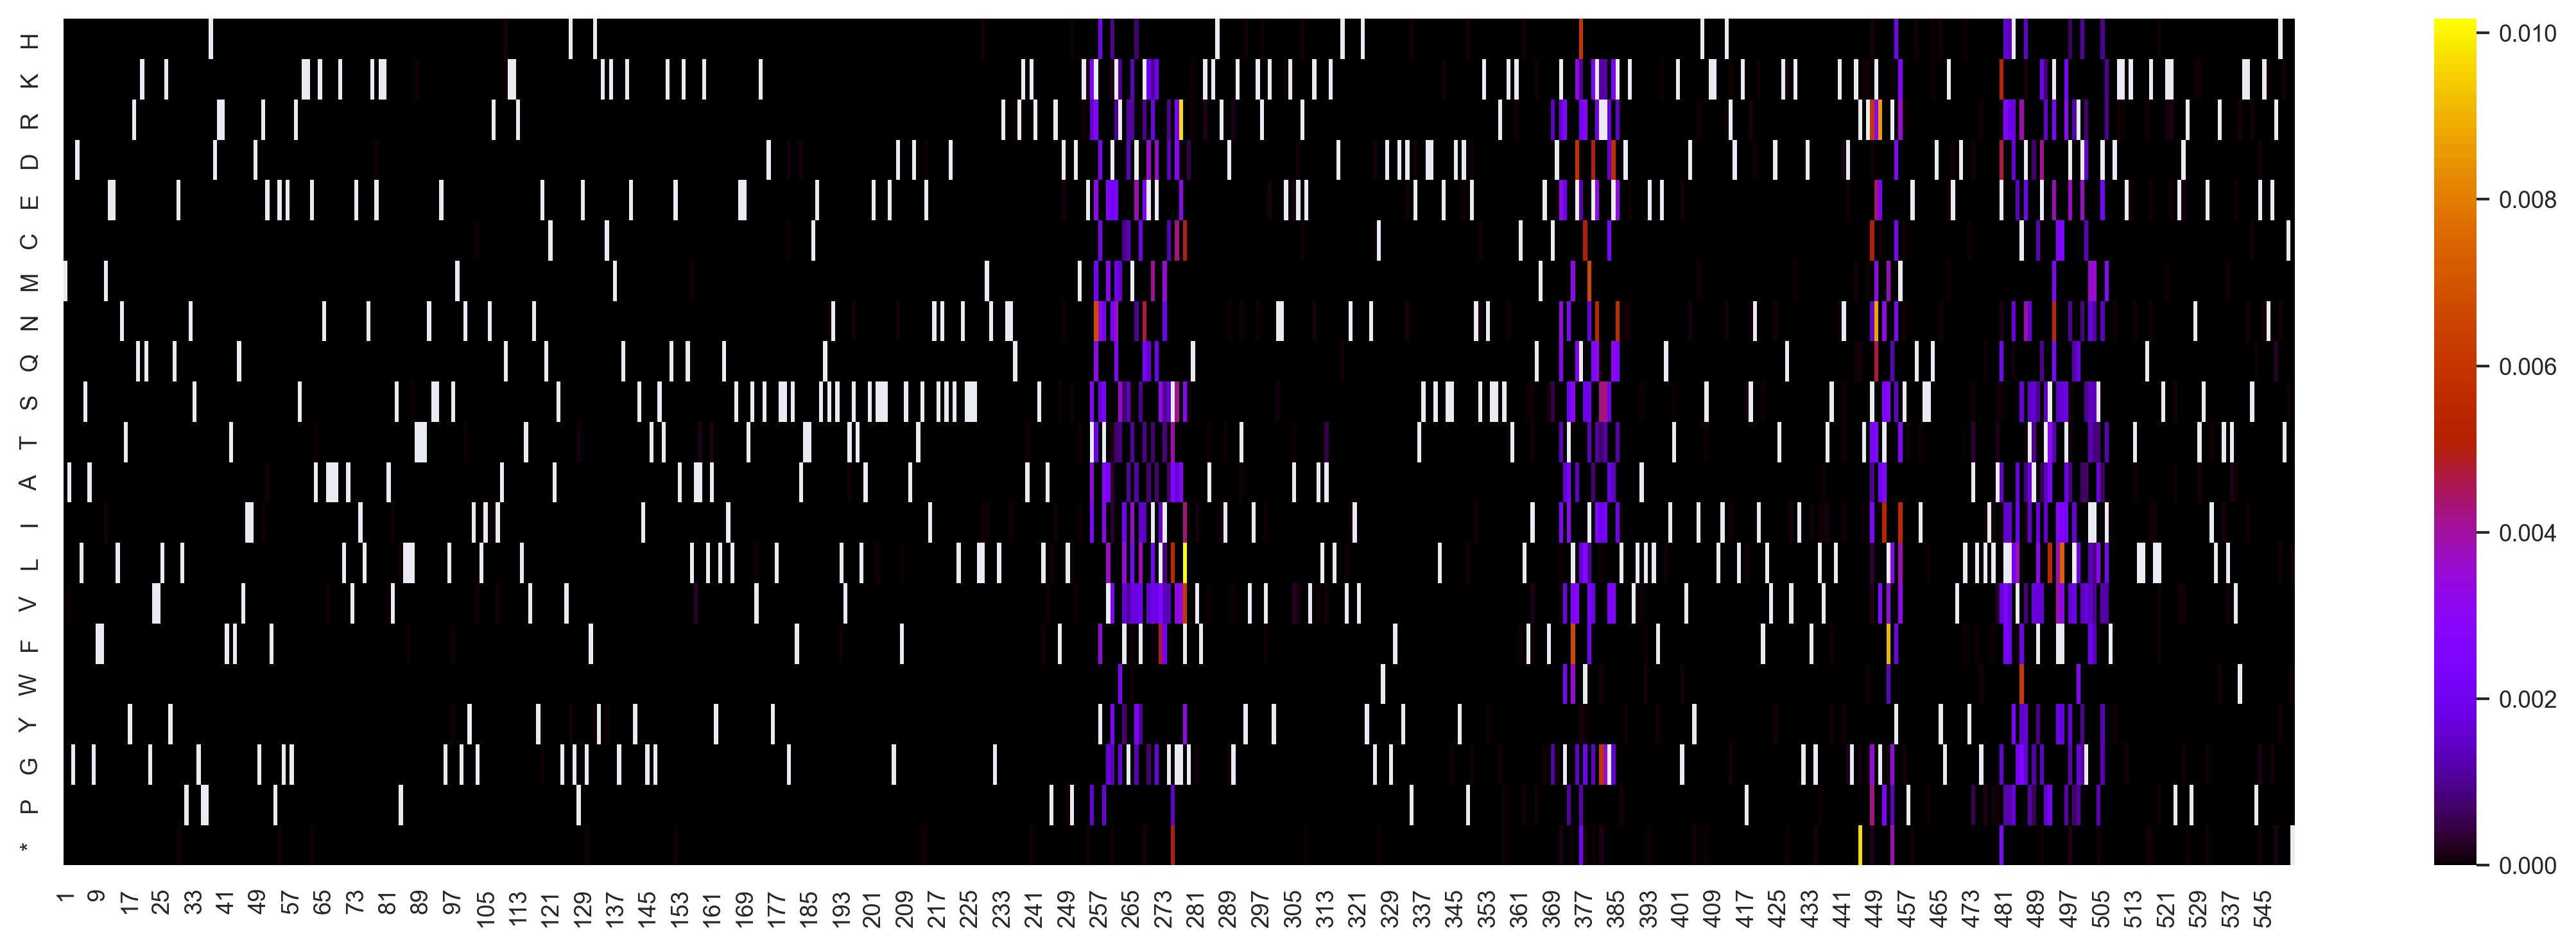

In [57]:
sns.set_context('paper')
plt.figure(figsize=(15,5))
ax = sns.heatmap(data=new_df.T, square=False, cbar=True, cmap='gnuplot')
ax.set(xlabel='')
ax.set(ylabel='')
fig = ax.get_figure()
plt.tight_layout()
fig.savefig('img/heatmap_pkr-dms.png')

In [58]:
new_df[new_df.index > 249]

mut_char,H,K,R,D,E,C,M,N,Q,S,...,A,I,L,V,F,W,Y,G,P,*
site,,,,,,,,,,,,,,,,,,,,,
250,0.000049,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000049,...,0.0,0.000000,0.000049,0.000000,0.0,0.000000,0.000000,0.0,NaN,0.000000
251,0.000000,0.000000,0.000000,NaN,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000049,0.0,0.000000,0.000000,0.0,0.0,0.000000
252,0.000000,0.000000,0.000000,0.0,0.0,0.0,NaN,0.000000,0.000000,0.000000,...,0.0,0.000049,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
253,0.000000,NaN,0.000049,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
254,0.000000,0.000147,0.000000,0.0,NaN,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548,0.000000,0.000000,NaN,0.0,0.0,0.0,0.0,0.000000,0.000246,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000147
549,NaN,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000049,0.000000,0.000000,...,0.0,0.000000,0.000049,0.000000,0.0,0.000000,0.000049,0.0,0.0,0.000000
550,0.000000,0.000049,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000


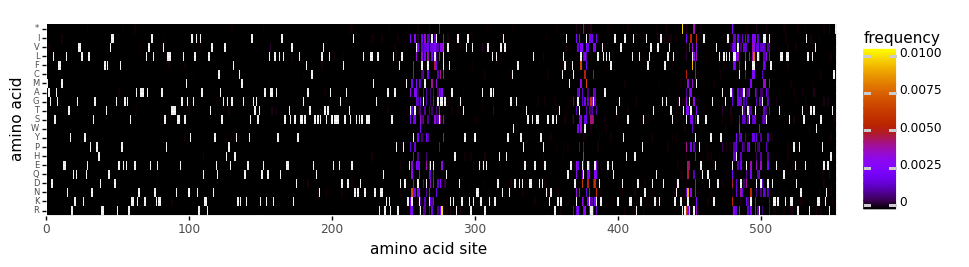

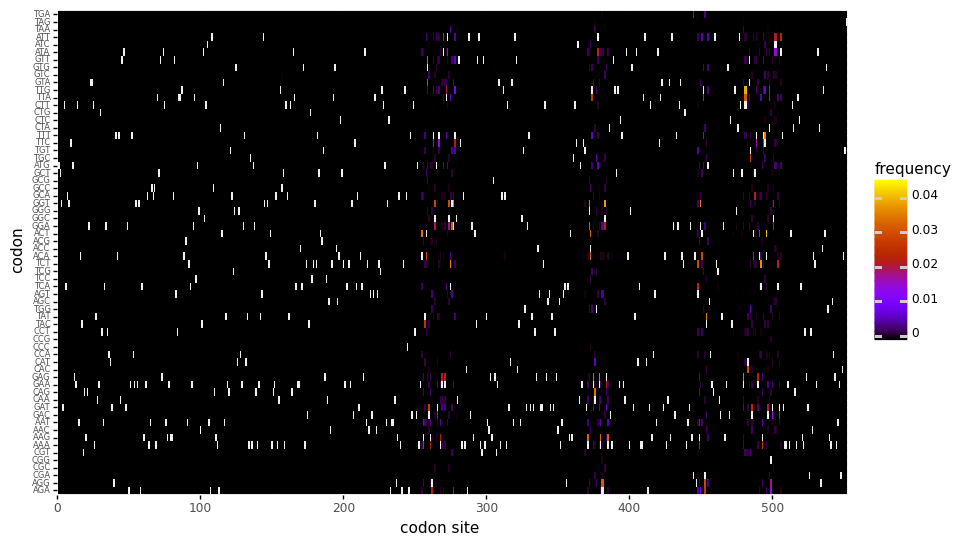

In [61]:
for mut_type in ['aa', 'codon']:
    p = pkr_variants.plotMutHeatmap('all', mut_type, samples=None,widthscale=2)
    p.draw()

In [71]:
# try getting a df of mut codons
pkr_variants.add_sample_counts_df(

<bound method CodonVariantTable.addSampleCounts of <dms_variants.codonvarianttable.CodonVariantTable object at 0x2aabf801d910>>

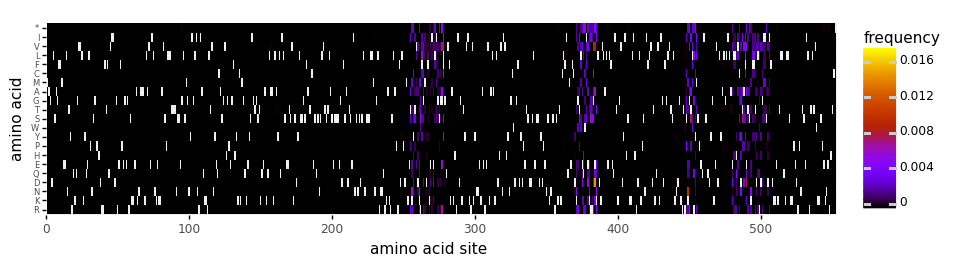

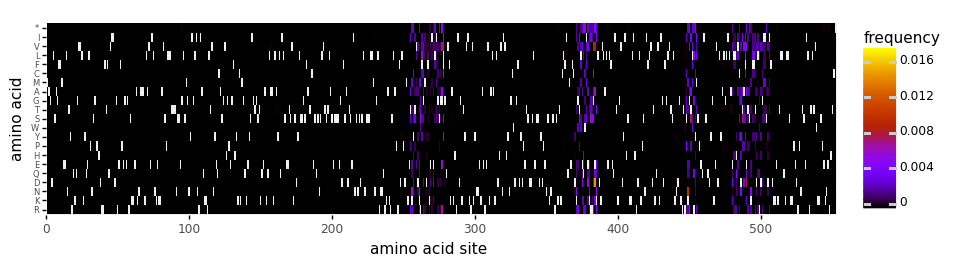

In [43]:
p = pkr_variants.plotMutHeatmap('all', 'aa', samples=None,widthscale=2)
p.draw()

In [62]:
pkr_variants.barcode_variant_df

,library,barcode,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions
0,pkr_lib,AAAAAAAAAAAAAATTCTTTTATGAG,7,GAA480GAT CTT481TTA CTT482TTG TGT485TGC,E480D,4,1
1,pkr_lib,AAAAAAAAAACGAAACCCTTTATTTT,2,GAC486AAC TTT489TTC GAA490GAG ACA491ACT,D486N,4,1
2,pkr_lib,AAAAAAAAAACTAATCCATTTTCACA,1,GAA480GAG CTT481TTA CTT482TTA CAT483CAC GTA484...,,6,0
3,pkr_lib,AAAAAAAAAAGAAACCTCCTTACTTA,5,GAA480TAG CTT481TTG CTT482TTA GTA484GTT TGT485TAT,E480* C485Y,5,2
4,pkr_lib,AAAAAAAAACAGAAAGTTATTATTTA,32,ATC502ATA ATC503ATG TCA504TCT ATA506ATT,I503M,4,1
...,...,...,...,...,...,...,...
20354,pkr_lib,TTTTTAAGCGCTAATAAACTTAGAAT,35,GAA480GAG CTT481TTG CTT482TTG CAT483CAC GTA484GTT,,5,0
20355,pkr_lib,TTTTTAAGGCTAAAAACGATTAAATA,32,ATG265ATT GAT266GAC GAA269GAG,M265I,3,1
20356,pkr_lib,TTTTTAAGGTCCAACATGATTTGCAT,42,AAG261AAA AGG262AGA GGC264GGT,,3,0
20357,pkr_lib,TTTTTAATACGGAAGACCCTTATCGG,21,ATC502ATT ATC503ACC ATA506ATT,I503T,3,1


In [63]:
# save pkr codon variant table
pkr_variants.barcode_variant_df.to_csv('output/variants/pkr.codon_variant_table.csv', index=False)